## SHAP (SHAPley Additive exPlanations)
* xAI (eXplaionable AI) : 설명 가능한 인공지능

## 라이브러리 준비

In [40]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 윈도우의 '맑은 고딕' 폰트 설정
plt.rc('font', family='Malgun Gothic')
# 마이너스 기호(-)가 깨지는 현상 방지
plt.rcParams['axes.unicode_minus'] = False
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_california_housing

## 데이터 확인

In [2]:
housing = fetch_california_housing()

In [3]:
housing

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]], shape=(20640, 8)),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894], shape=(20640,)),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': 

In [4]:
# 데이터프레임화
X = pd.DataFrame(housing.data, columns = housing.feature_names)
Y = housing.target

# 데이터셋 분할
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [5]:
# 데이터 정보 확인
print("="*50)
print(f'학습 데이터 상위 5개')
print(x_train.head())
print("="*50)
print('\n'f'학습 데이터 정보')
print(x_train.info())
print("="*50)

학습 데이터 상위 5개
       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
14196  3.2596      33.0  5.017657   1.006421      2300.0  3.691814     32.71   
8267   3.8125      49.0  4.473545   1.041005      1314.0  1.738095     33.77   
17445  4.1563       4.0  5.645833   0.985119       915.0  2.723214     34.66   
14265  1.9425      36.0  4.002817   1.033803      1418.0  3.994366     32.69   
2271   3.5542      43.0  6.268421   1.134211       874.0  2.300000     36.78   

       Longitude  
14196    -117.03  
8267     -118.16  
17445    -120.48  
14265    -117.11  
2271     -119.80  

학습 데이터 정보
<class 'pandas.DataFrame'>
Index: 16512 entries, 14196 to 15795
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      16512 non-null  float64
 1   HouseAge    16512 non-null  float64
 2   AveRooms    16512 non-null  float64
 3   AveBedrms   16512 non-null  float64
 4   Population  16512 non-null  float6

### 캘리포니아 데이터셋 피처

| 변수명 | 의미 |
| :--- | :--- |
| **MedInc** | 중위 소득 |
| **HouseAge** | 건물 연령 |
| **AveRooms** | 평균 방 개수 |
| **AveBedrms** | 평균 침실 수 |
| **Population** | 인구 수 |
| **AveOccup** | 평균 가구원 수 |
| **Latitude** | 위도 |
| **Longitude** | 경도 |

### 모델 학습

In [ ]:
# 1. 모델 정의 및 훈련 (랜덤포레스트)
model = RandomForestRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)
model.fit(x_train, y_train)

# 2. SHAP 시각화 준비
shap.initjs()

# 3. SHAP 엔진 생성 및 값 계산
# 속도 향상을 위해 전체 데이터가 아닌 테스트 데이터 중 100개 데이터만 한다
x_test_sample = x_test.sample(n = 100, random_state = 42)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test_sample)

# 4. 결과 확인
print(f'기본 기대값 : {explainer.expected_value[0]:.4f}') # Base가 되는 값
print(f'SHAP : {shap_values.shape}')

기본 기대값 : 2.0731
SHAP : (100, 8)


* SHAP는 각 피처가 결과에 미치는 영향을 계산하기 위해 수 많은 조합을 시뮬레이션 한다.
* 테스트 데이터 4,128개에 100개의 나무를 계산하므로 시간이 걸림
* 속도를 향상 하기 위해서는 테스트 데이터의 전체가 아닌 테스트 데이터의 샘플 데이터를 뽑아서 계산하는 것이 효율적이다. (예 : X_test[:100])

### 시각화

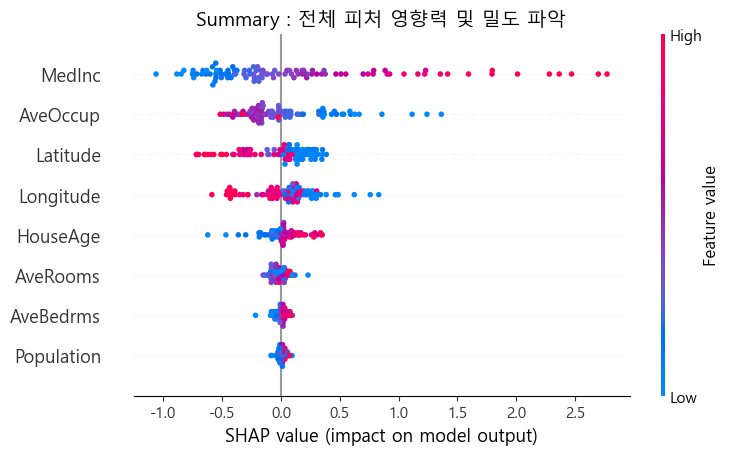

In [41]:
# 1. Summary, Beeswarm
plt.figure(figsize = (10,6))
shap.plots.beeswarm(explainer(x_test_sample), show = False)
plt.title('Summary : 전체 피처 영향력 및 밀도 파악', fontsize = 14)
plt.show()